# Wordle

[Wordle](https://www.powerlanguage.co.uk/wordle/) is a word game that Josh Wardle developed in October 2021. The game took off in popularity over the next few months with The New York Times even [covering the game and the story of its creation](https://www.nytimes.com/2022/01/03/technology/wordle-word-game-creator.html) in January 2022.

I love word games and I love playing Wordle. I also love programming. This notebook follows my processes of analyzing how to find good Wordle guesses and building a Wordle-solving program.

## Measuring letter frequency
An obvious way to choose good guesses in Wordle is to use words that use common letters like a, e, i, o, or u and not words that contain rarer letters like q, x, or z.

A quick internet search will tell you that the most frequently-occurring letters in English are e, t, a, i, o, n, s, h, and r. However, Wordle doesn't use every word in the English language: each guess must be a valid **5 letter word**. In order to find good guesses in Wordle we should only consider how frequently letters appear in valid 5 letter words.

We don't know which dictionary Wordle uses to determine all valid five letter words, but the [Collins Scrabble Words](https://en.wikipedia.org/wiki/Collins_Scrabble_Words) or "SOWPODS" dictionary will be a decent approximation.

In [24]:
from collections import Counter
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
with open("data/sowpods.txt", "r") as sowpods:
    wordle_lexicon = [word.strip() for word in sowpods if len(word.strip()) == 5]

In [53]:
wordle_df = pd.DataFrame(wordle_lexicon, dtype="string")
pos_frequencies = [Counter(wordle_df[0].str[i]) for i in range(5)]
total_frequency = reduce(lambda a, b: a + b, pos_frequencies)

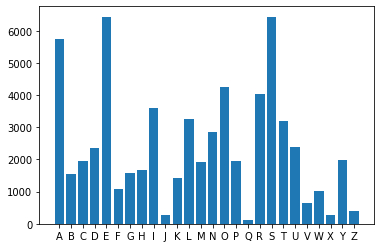

In [54]:
frequencies = [total_frequency[c] for c in letters]
plt.bar(letters, frequencies)
plt.show()

In addition to the total frequency of letters it might be interesting to look at how frequently each letter appears in each position of valid five letter words:

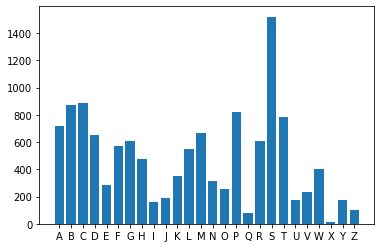

In [55]:
idx_0_frequencies = [pos_frequencies[0][c] for c in letters]
plt.bar(letters, idx_0_frequencies)
plt.show()

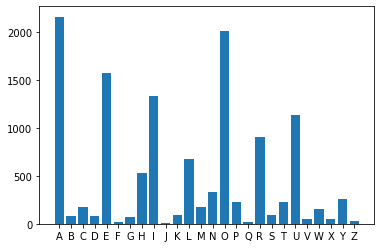

In [36]:
idx_1_frequencies = [pos_frequencies[1][c] for c in letters]
plt.bar(letters, idx_1_frequencies)
plt.show()

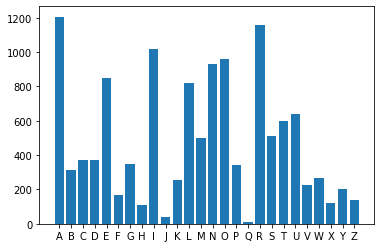

In [37]:
idx_2_frequencies = [pos_frequencies[2][c] for c in letters]
plt.bar(letters, idx_2_frequencies)
plt.show()

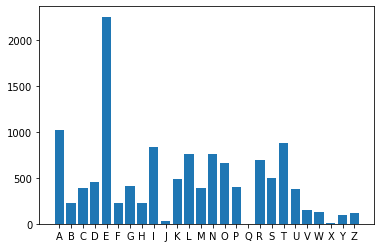

In [58]:
idx_3_frequencies = [pos_frequencies[3][c] for c in letters]
plt.bar(letters, idx_3_frequencies)
plt.show()

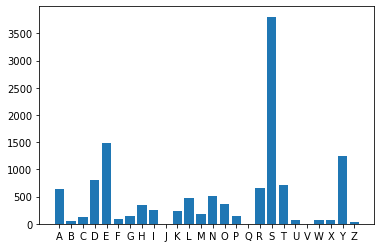

In [59]:
idx_4_frequencies = [pos_frequencies[4][c] for c in letters]
plt.bar(letters, idx_4_frequencies)
plt.show()

## Making good _first_ guesses
### Sorting by letter frequency
When we don't know _any_ of the correct letters in the word a good first guess might be to try a word that uses the most frequently-occurring letters. To find words like this we can sort all of the words in dictionary according to the sum of the total frequencies of their letters:

In [129]:
by_total = lambda word: -sum([total_frequency[c] for c in word])
words_by_total = sorted(wordle_lexicon, key=by_total)
print("\n".join(words_by_total[:10]))

ESSES
EASES
SEASE
ASSES
SASSE
SESSA
RESEE
ERSES
RESES
SEERS


Unfortunately, `ESSES` doesn't make for a very good guess in Wordle: it only has two unique letters!

Updating the sort key function to count unique letters may help to identify good _first_ guesses in Wordle.

In [130]:
by_total_uniq = lambda word: -sum([total_frequency[c] for c in set(word)])
words_by_total_uniq = sorted(wordle_lexicon, key=by_total_uniq)
print("\n".join(words_by_total_uniq[:10]))

AEROS
AROSE
SOARE
AESIR
ARISE
RAISE
SERAI
ALOES
STOAE
TOEAS


We might also try words that have letters that frequently occur in each given position in five letter words:

In [127]:
by_pos = lambda word: -(
    pos_frequencies[0][word[0]] +
    pos_frequencies[1][word[1]] +
    pos_frequencies[2][word[2]] +
    pos_frequencies[3][word[3]] +
    pos_frequencies[4][word[4]]
)
words_by_pos = sorted(wordle_lexicon, key=by_pos)
print("\n".join(words_by_pos[:10]))

SORES
SANES
SALES
SONES
SOLES
SATES
SERES
CARES
BARES
SAMES


This list of words seems like a good list of guesses, but we can also construct a sort key that considers _both_ the total frequency and the positional frequency of each letter in the word:

In [131]:
def by_total_and_pos(word: str, w_total: float = 1.0, w_pos: float = 1.0) -> float:
    return w_total * by_total_uniq(word) + w_pos * by_pos(word)

words_by_total_and_pos = sorted(wordle_lexicon, key=by_total_and_pos)
print("\n".join(words_by_total_and_pos[:10]))

TARES
LARES
RALES
RATES
NARES
DARES
TALES
CARES
AEROS
PARES


## Solving a Wordle puzzle

The analyses until this point have focused on identifying good candidates for a first guess in Wordle. How can we adapt these functions to make second and third guesses and work towards building a Wordle solver?

We need some way to find possible words once we've already correctly filled in some of the letters in the word. For example, we need a way to find possible words that match `M__CH`.

### WildTrieNode and wildcard search
A [trie](https://en.wikipedia.org/wiki/Trie) or prefix tree is a data structure commonly used for applications like spell checking or autocomplete. It also works well for many word games like Boggle (and Wordle).

The implementation of `WildTrieNode`, below, uses a trie structure to implement wildcard search. Each `"_"` character in the search string can be replaced by any possible character. For example, `"M__CH"` matches `"MATCH"`, `"MARCH"`, and `"MULCH"`, among others.

The wildcard search works by combining the results of searching all available paths `"MA_CH"`, `"MU_CH"`, etc. once the search reaches the first `"_"`.

In [182]:
from functools import reduce
from typing import Dict
from typing import List
from typing import Set


class WildTrieNode:
    """A Trie data structure that supports wildcard search."""
    
    def __init__(self):
        self.children: Dict[str, WildTrieNode] = {}
        self.is_end = False
    
    def insert(self, word: str) -> None:
        if len(word) == 0:
            self.is_end = True
            return
        head, tail = word[0], word[1:]
        child = self.children.get(head, WildTrieNode())
        child.insert(tail)
        self.children[head] = child
    
    def search(self, word: str, to_ignore: Set[str] = None) -> List[str]:
        """Performs wildcard search for words in the Trie.
        
        The character '_' in the input word could be any character A-Z.
        """
        if len(word) == 0:
            return [""] if self.is_end else []
        head, tail = word[0], word[1:]
        if head == "_":
            child_lists = (
                [k + found for found in v.search(tail, to_ignore)]
                for k, v in self.children.items() if to_ignore is None or k not in to_ignore
            )
            return reduce(
                lambda a, b: a + b,
                child_lists,
                []
            )
        
        if head not in self.children:
            return []
        return [head + found for found in self.children[head].search(tail, to_ignore)]

Let's do a bit of testing to make sure that this trie works as expected:

In [184]:
wild_trie = WildTrieNode()
test_wordlist = ["AAH", "AAHED", "ASHES", "ASSET", "ASHRAM"]
for word in test_wordlist:
    wild_trie.insert(word)
    
assert wild_trie.search("_____") == ["AAHED", "ASHES", "ASSET"]
assert wild_trie.search("A____") == ["AAHED", "ASHES", "ASSET"]
assert wild_trie.search("___") == ["AAH"]
assert wild_trie.search("______") == ["ASHRAM"]
assert wild_trie.search("_____", to_ignore={"S"}) == ["AAHED"]

for word in ["MATCH", "MARCH", "MULCH"]:
    wild_trie.insert(word)
    
assert wild_trie.search("M__CH") == ["MATCH", "MARCH", "MULCH"]

### Putting it all together: WordleGuesser

Now that we have a way to rank guesses (sorting based on frequency) and a way to do wildcard searches for possible guesses (WildTrieNode) we can put the two together to build a tool for making educated guesses:

In [181]:
from collections import Counter
from itertools import permutations

import pandas as pd


class WordleGuesser:
    """An object that helps to make educated guesses in Wordle games."""
    
    def __init__(self):
        self.wild_trie = WildTrieNode()
        wordle_lexicon = []
        with open("data/sowpods.txt", "r") as sowpods:
            for word in sowpods:
                stripped_word = word.strip()
                if len(stripped_word) == 5:
                    self.wild_trie.insert(stripped_word)
                    wordle_lexicon.append(stripped_word)
            
        wordle_df = pd.DataFrame(wordle_lexicon, dtype="string")
        self._pos_frequencies = [Counter(wordle_df[0].str[i]) for i in range(5)]
        self._total_frequency = reduce(lambda a, b: a + b, pos_frequencies)
        
    def _sort_word_list(self, word_list: List[str], w_total: float = 2.0, w_pos: float = 1.0) -> List[str]:
        """Sorts a list of words based on the frequencies of letters in each word in the lexicon"""
        by_total = lambda word: -sum([self._total_frequency[c] for c in set(word)])
        by_pos = lambda word: -(
            self._pos_frequencies[0][word[0]] +
            self._pos_frequencies[1][word[1]] +
            self._pos_frequencies[2][word[2]] +
            self._pos_frequencies[3][word[3]] +
            self._pos_frequencies[4][word[4]]
        )
        # weight the results of by_total and by_pos according to w_total and w_pos
        return sorted(word_list, key=lambda w: w_total * by_total(w) + w_pos * by_pos(w))
        
    def guess(self, known_word: str, known_letters: Dict[str, Set[int]], ignore_letters: Set[str]) -> List[str]:
        """Provides a list of good guesses based on information from the Wordle game.
        
        Args:
            known_word: the word so far with letters in the correct spot
            known_letters: a mapping from letters in the word to the set of indices already tried for that letter
            ignore_letters: the set of letters known not to be in the word
            
        Returns:
            a list of up to ten possible words, ordered by `_sort_word_list`
        """
        search_starts = self._get_search_starts(known_word, known_letters)
        # convert list of words to a set to remove duplicates
        word_list = list(set(reduce(
            lambda a, b: a + b,
            [self.wild_trie.search(w, ignore_letters) for w in search_starts]
        )))
        return self._sort_word_list(word_list)[:10]
    
    def _get_search_starts(self, known_word: str, known_letters: Dict[str, Set[int]]) -> List[str]:
        """Generates search stems to use with WildTrieNode based on Wordle game information"""
        if not known_letters:
            return [known_word]
        
        unk_indices = [i for i, c in enumerate(known_word) if c == "_"]
        
        # generate lists of all possible pairings between known letters and indices without letters
        letter_placements = (list(zip(idx, known_letters)) for idx in permutations(unk_indices, len(known_letters)))
        search_starts = []
        for placement in letter_placements:
            if any(i in known_letters[c] for i, c in placement):
                # skip any placement that places a known letter in a spot it's already been tried
                continue
            possible_word = known_word
            for i, c in placement:
                possible_word = possible_word[:i] + c + possible_word[i + 1:]
            search_starts.append(possible_word)
        return search_starts

### `_get_search_starts`

The trie data structure implemented above, `WildTrieNode`, supports wildcard search for words with only a subset or even no letters filled in such as `"W_RDS"` or `"_____"`. What if we know that a letter is in the word, but we don't know the correct spot?

Suppose we've made a guess and known that the correct word looks like `"S___S"` and that we know it contains the letter `"T"`, but not at index 1. In order to find all of the possible matches we can consider all words that match searches starting at either `"S_T_S"` or `"S__TS"`.

`_get_search_starts` uses the list of known letters with unknown spots and the indices with unknown letters in the word so far to form the possible search starts like `"S_T_S"` and `"S__TS"` in the example above.

### Testing WordleGuesser

I tested WordleGuesser on a real Wordle game on 1/20/22. It worked!

With the help of WordleGuesser I solved the puzzle using four of six tries. After three tries there was only one word left that fit the information that I had: `"ROBOT"`.

In [180]:
guesser = WordleGuesser()
guesser.guess("_____", [], {})
# TARES
guesser.guess("_____", {"T": {0}, "R": {2}}, set("AES"))
# NITRO
guesser.guess("_____", {"T": {0, 2}, "R": {2, 3}, "O": {4}}, set("AESNI"))
# ROUTH
guesser.guess("RO___", {"T": {0, 2, 3}}, set("AESNIUH"))
# ROBOT
# Correct!

['ROBOT']

I think that playing Wordle is more fun _without_ a computer's help, but building WordleGuesser was fun, too!